In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
from prophet import Prophet
import pandas as pd 
orig_df = pd.read_csv("resource/kz.csv")

In [3]:
sales_df = orig_df.copy()
sales_df['event_time'] = sales_df['event_time'].apply(lambda x: x.replace("UTC", ""))
#sales_stripped_df = pd.DataFrame(sales_df, columns = ['event_time','order_id'], index = ['event_time'])
sales_df['event_time'] = pd.to_datetime(sales_df['event_time'])
sales_df_stripped = sales_df[[ 'event_time', 'order_id']]
sales_df_stripped_per_hr = sales_df_stripped.groupby(pd.Grouper(key='event_time', axis=0, freq='H')).count()
sales_df_stripped_per_hr = sales_df_stripped_per_hr.loc['2021-01-01':'2021-12-31'].loc[sales_df_stripped_per_hr['order_id'] > 100].loc[sales_df_stripped_per_hr['order_id'] < 500]
sales_df_stripped_per_hr.dropna(inplace=True)


In [4]:
sales_df_stripped_per_hr.tail() 

,order_id
event_time,
2021-11-18 14:00:00,366
2021-11-18 15:00:00,183
2021-11-19 04:00:00,351
2021-11-19 14:00:00,380
2021-11-19 15:00:00,157


In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    '''
    Summary:
    -------
    Plots various plots, including time series, autocorrelation,
    partial autocorrelation and distribution plots of data.
    
    Parameters:
    ----------
    ts_plot_name(String): The name of the time series plot
    data(pd.Dataframe, pd.Series, array): Time Series Data
    
    Returns:
    --------
    None
    
    '''
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Sales')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=24);
    plot_pacf(data, ax=axes[0,1], lags=24);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

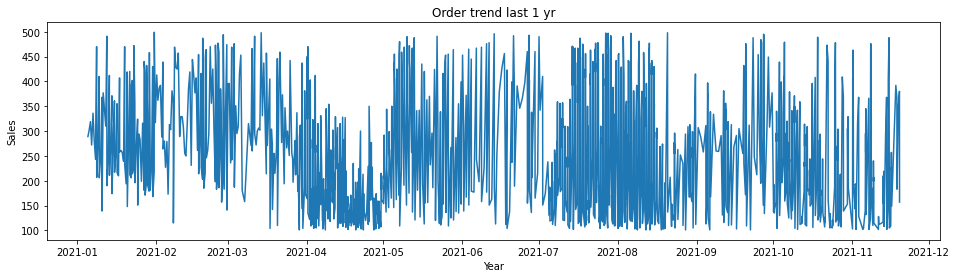

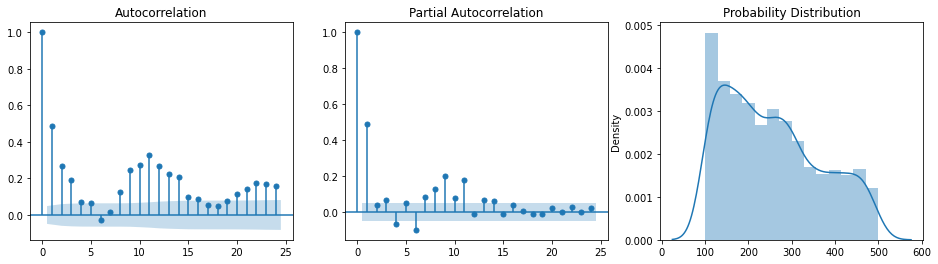

In [7]:
plot_data_properties(sales_df_stripped_per_hr, 'Order trend last 1 yr');

By a visual look, one can see 

The data is not stationary, so we need to decompose the data into trend, seasonality and residuals

TODO: later add dufuller test to rule out..

The data is also additive in nature . not multiplicative

In [8]:
def plot_seasonal_decompose(data, model):
    '''
    Summary:
    -------
    Plots trend, seasonality and residuals with bigger plot size=(10,2)
    
    Parameters:
    ----------
    data(pd.Dataframe, pd.Series): time series data
    
    Return:
    ------
    decomposition(obj): return value of statsmodels.tsa.seasonal.seasonal_decompose
    '''
    decomposition = seasonal_decompose(data,model=model,period=1)
    decomposition.trend.plot(figsize=(10,2), title='Trend');
    decomposition.seasonal.plot(figsize=(10,2), title='Seasonality');
    decomposition.resid.plot(figsize=(10,2), title='Residuals');
    return decomposition

In [9]:
from sklearn.model_selection import train_test_split
sales_df_stripped_per_hr.sort_index(inplace=True)
#X_train, X_test = train_test_split(sales_df_stripped_per_hr, test_size=0.3, shuffle=False)

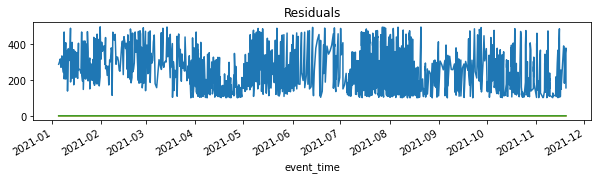

In [12]:
decomposition = plot_seasonal_decompose(sales_df_stripped_per_hr, 'additive')

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(data):
    '''
    Summary:
    -------
    Performs Adfuller test on given time series data to test stationarity.
    p_val >= 0.05 means the data is not stationary, otherwise (p_val < 0.05) it is stationary.
    
    Parameters:
    data(pd.Dataframe, pd.Series. np.array): Time series data to be tested
    
    Return:
    ------
    '''
    p_val=adfuller(data)[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))

SARIMA needs the data to be stationary. 
There are two ways to make it stationary 
1. Shifting difference
2. Using logged transformed method to make it
stationary

In [14]:
sales_df_stripped_per_hr_seasonal = sales_df_stripped_per_hr.copy()
sales_df_stripped_per_hr_seasonal['order_id_seasonal'] = sales_df_stripped_per_hr_seasonal['order_id']-sales_df_stripped_per_hr_seasonal['order_id'].shift(24)

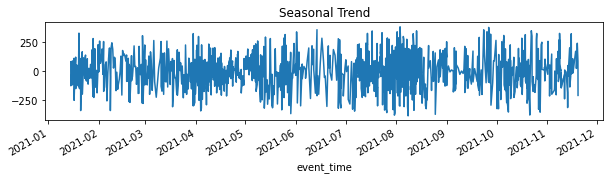

In [15]:
sales_df_stripped_per_hr_seasonal['order_id_seasonal'].plot(figsize=(10,2), title='Seasonal Trend');

In [16]:

sales_shifted = sales_df_stripped_per_hr_seasonal['order_id_seasonal'].dropna().loc[sales_df_stripped_per_hr_seasonal['order_id_seasonal'] > 0]
sales_df_shifted = sales_shifted.to_frame()
test_stationarity(sales_df_shifted['order_id_seasonal'])
sales_df_shifted


Time series data is stationary. Adfuller test pvalue=4.945101212394092e-22


,order_id_seasonal
event_time,
2021-01-14 14:00:00,82.0
2021-01-15 14:00:00,89.0
2021-01-16 14:00:00,112.0
2021-01-17 04:00:00,3.0
2021-01-17 14:00:00,122.0
...,...
2021-11-18 04:00:00,173.0
2021-11-18 14:00:00,156.0
2021-11-18 15:00:00,24.0


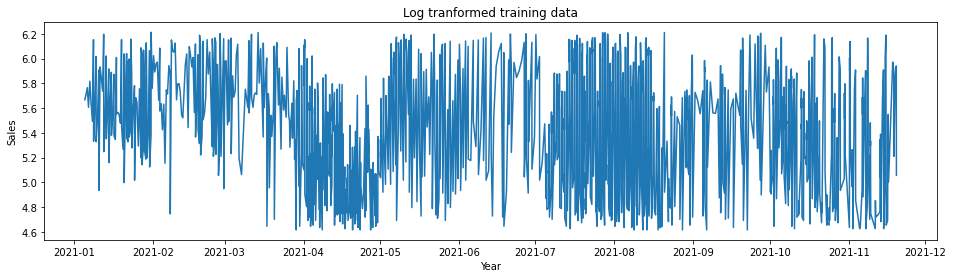

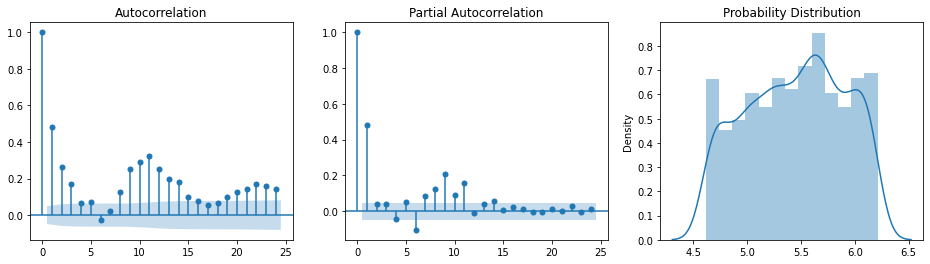

In [17]:
import numpy as np
log_transformed_data = np.log(sales_df_stripped_per_hr)
plot_data_properties(log_transformed_data, 'Log tranformed training data')

In [18]:
test_stationarity(log_transformed_data)

Time series data is stationary. Adfuller test pvalue=1.1406824505162367e-06


So log transformed data is not good enough.
lets take the shifted data going forward as the (adfuller) p value is less 

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
def best_sarima_model(train_data,p,q,P,Q,d=1,D=1,s=24):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model so far: SARIMA" +  str(best_model_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))

                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models  

In [21]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(log_transformed_data['order_id'],order=(1, 1, 1),seasonal_order=(0,1,1,24))
results=model.fit()

In [22]:
log_transformed_data.size

1609

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           order_id   No. Observations:                 1609
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood                -811.323
Date:                            Tue, 07 Jun 2022   AIC                           1630.645
Time:                                    21:38:43   BIC                           1652.116
Sample:                                         0   HQIC                          1638.622
                                           - 1609                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4032      0.025     16.422      0.000       0.355       0.451
ma.L1         -0.9697      0.006   -149.323      0.000      -0.982      -0.957
ma.S.L24      -0.9992      0.488     -2.046      0.041      -1.956      -0.042
sigma2         0.1528      0.074      2.053      0.040       0.007       0.299
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                22.08
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.21
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,order_id,forecast
event_time,,
2021-11-18 14:00:00,5.902633,5.288244
2021-11-18 15:00:00,5.209486,5.185562
2021-11-19 04:00:00,5.860786,5.163939
2021-11-19 14:00:00,5.940171,5.079243
2021-11-19 15:00:00,5.056246,5.192195


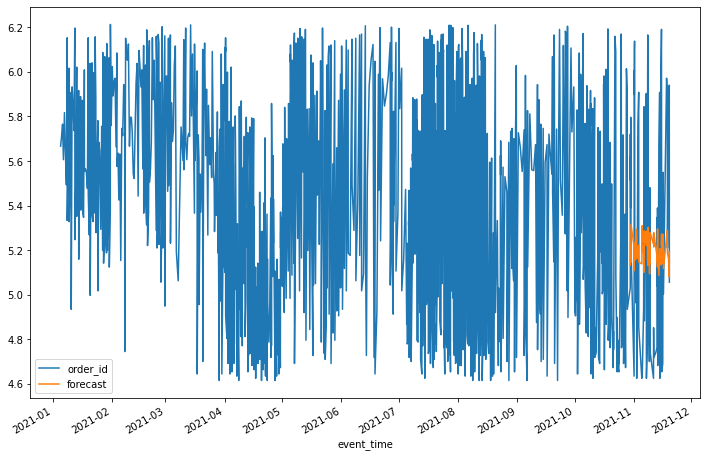

In [49]:
sales_df_pred = log_transformed_data.copy()
sales_df_pred['forecast']=results.predict(start=1500,end=1608,dynamic=True)
sales_df_pred[['order_id','forecast']].plot(figsize=(12,8))
sales_df_pred.tail()

In [50]:
datetime_series = pd.Series(
    pd.date_range(sales_df_pred.index[-1], periods=180*24, freq="h")
)
#datetime_series.tail()
future_datest_df=pd.DataFrame(index=datetime_series[1:],columns=sales_df_pred.columns)
future_datest_df.head()

,order_id,forecast
2021-11-19 16:00:00,NaN,NaN
2021-11-19 17:00:00,NaN,NaN
2021-11-19 18:00:00,NaN,NaN
2021-11-19 19:00:00,NaN,NaN
2021-11-19 20:00:00,NaN,NaN


In [51]:
sales_df_pred.size

3218

In [42]:
future_df=pd.concat([sales_df_pred,future_datest_df],axis=0)
future_df.reindex()

,order_id,forecast
2021-01-05 04:00:00,5.666427,NaN
2021-01-05 15:00:00,5.707110,NaN
2021-01-06 04:00:00,5.765191,NaN
2021-01-06 15:00:00,5.605802,NaN
2021-01-07 04:00:00,5.817111,NaN
...,...,...
2022-05-18 10:00:00,NaN,NaN
2022-05-18 11:00:00,NaN,NaN
2022-05-18 12:00:00,NaN,NaN
2022-05-18 13:00:00,NaN,NaN


                     order_id  forecast
2021-01-05 15:00:00  5.707110       NaN
2021-01-06 04:00:00  5.765191       NaN
2021-01-06 15:00:00  5.605802       NaN
2021-01-07 04:00:00  5.817111       NaN
2021-01-07 15:00:00  5.645447       NaN
...                       ...       ...
2021-02-07 17:00:00  4.744932       NaN
2021-02-08 04:00:00  6.150603       NaN
2021-02-08 15:00:00  6.059123       NaN
2021-02-09 04:00:00  6.052089       NaN
2021-02-09 15:00:00  6.124683       NaN

[99 rows x 2 columns]


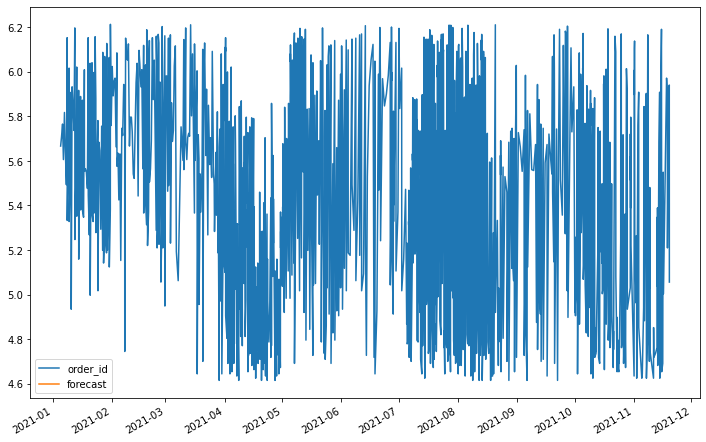

In [54]:
future_df['forecast']=results.predict(start=1600,end=2000,dynamic=True)
future_df[['order_id', 'forecast']].plot(figsize=(12, 8)) 
print(future_df.iloc[1:100])

In [44]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [59]:
#future_df.dropna(inplace=True)
evaluate_forecast(sales_df_pred.iloc[1550:-1]['order_id'],sales_df_pred.iloc[1550:-1]['forecast'])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.119149,0.389917,0.372405,0.232948,0.005713,0.07211,0.482646
